# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
# load P1D emulator
emu=linear_emulator.LinearEmulator(verbose=False)

setup interpolator for coefficient 0
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-1.18323575]
setup interpolator for coefficient 1
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.6323589]
setup interpolator for coefficient 2
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.29370814]
setup interpolator for coefficient 3
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.1279153]
setup interpolator for coefficient 4
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.01945575]


In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)
# for this simple test, just use fiducial cosmology
theory.set_cosmo_model(linP_model=theory.cosmo.linP_model_fid)
linP_Mpc_params=theory.cosmo.get_linP_Mpc_params()

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [5]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
likelihood setup with 1 free parameters
1 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414


In [7]:
# test likelihood function
values=[0.5]
like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)

updated parameters, update theories
updated 1 mean flux parameters
updated 1 IGM parameters
0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.82678076324723049, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.79400932502668009, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12744692725288601}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835, 'alpha_p': -0.21637578130992885, 'f_p': 0.97499691285123324, 'mF': 0.75832916245871795, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12436389094838281}
3 2.8 model {'Delta2_p': 0.39841920050635804, 'n_p': -2.2994793725990892, 'alpha_p': -0.21637637290771081, 'f_p': 0.97850450521187982, 'mF': 0.71997791172041337, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12144623367196278}
4 3.0 model 

-3468.4367447707523

In [8]:
#cProfile.run("like.get_chi2(linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [9]:
def log_prob(x,like,linP_Mpc_params):
    return like.log_prob(values=x,linP_Mpc_params=linP_Mpc_params)

In [10]:
like.go_silent()

In [11]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like,linP_Mpc_params) for x in xs]

-1.2 < ln_tau_0 < -0.7
0.301194211912 < tau_0 < 0.496585303791
0.608605317804 < <F> < 0.739934054784


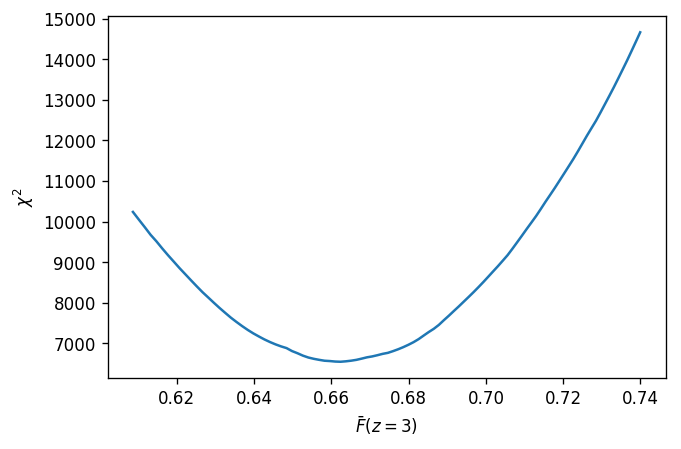

In [12]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [13]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [14]:
p0.flatten()

array([ 0.8715381 ,  0.12357713,  0.53152281,  0.27913192,  0.52079707,
        0.29279367,  0.5677928 ,  0.6706715 ,  0.69543177,  0.71809103])

In [15]:
# test function
log_prob(p0[0],like,linP_Mpc_params)

-4082.6707502749541

In [16]:
# setup sampler
emu.arxiv.verbose=False
emu.verbose=False
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like,linP_Mpc_params])

In [17]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [ 0.63288315  0.62673405  0.62363605  0.62411535  0.6299269   0.62691017
  0.61685387  0.63247616  0.62984922  0.62450294] [-3275.58814689 -3274.32052543 -3274.81269061 -3274.51545189 -3274.86222266
 -3274.33785541 -3279.24222852 -3275.47599746 -3274.84591516 -3274.27900948]


In [18]:
# reset and run actual chains
sampler.reset()
nsteps=500
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0].flatten())

0 [ 0.6314039   0.62405371  0.62348037  0.62482578  0.62989155  0.62514843
  0.61685387  0.63243657  0.63211839  0.6244264 ]
100 [ 0.62590604  0.62393948  0.62153703  0.6253955   0.62414818  0.62591908
  0.62963638  0.62535467  0.62887464  0.62946292]
200 [ 0.62393606  0.62528271  0.6249516   0.63346601  0.62694664  0.62583238
  0.63025429  0.63688643  0.62982094  0.62608769]
300 [ 0.62429835  0.62947473  0.63351704  0.62697082  0.62505256  0.63658369
  0.62850126  0.62192383  0.6305813   0.62296314]
400 [ 0.63857031  0.62099682  0.62805121  0.6309948   0.62525816  0.61888053
  0.6313991   0.62786127  0.62772251  0.6296634 ]


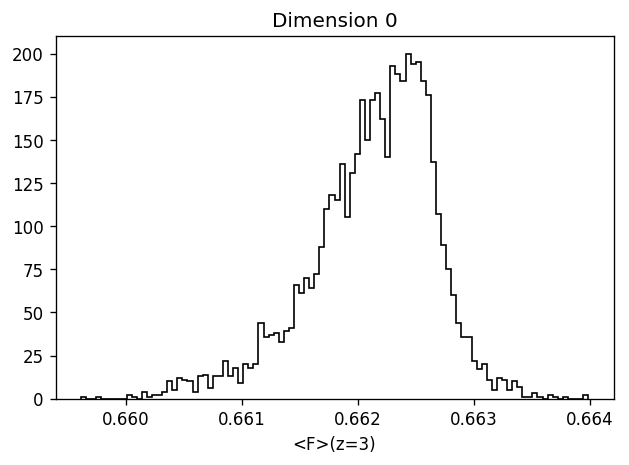

In [19]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [20]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.798


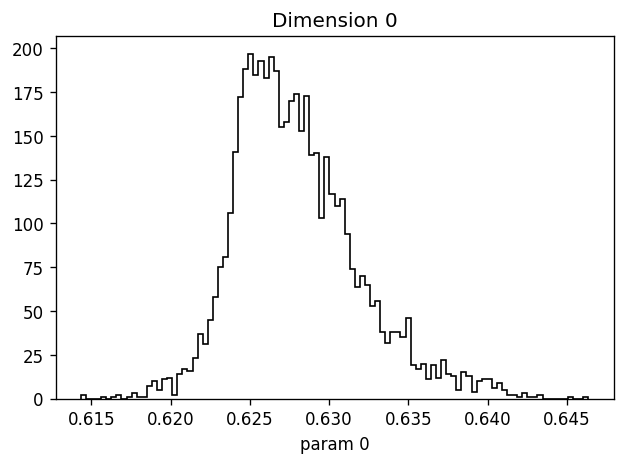

In [21]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))